# 200816 Expt.304: Titration of HEK293T cCL inputs for timsTOF  
_NB: This demonstration analysis was performed on unpublished development data. This experiment is intended to find the limit of detection for RNP inputs as defined by their extraction from X no. cells using the OdT-based purfication method._  
  
__Aims:__  
This is a simple titration of inputs.  
Analysis is provided as an example for datasets that contain only one experiment with n=1 sample per group.  

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#200816-Expt.304:-Titration-of-HEK293T-cCL-inputs-for-timsTOF" data-toc-modified-id="200816-Expt.304:-Titration-of-HEK293T-cCL-inputs-for-timsTOF-1">200816 Expt.304: Titration of HEK293T cCL inputs for timsTOF</a></span><ul class="toc-item"><li><span><a href="#1.-Import-Modules-and-Files" data-toc-modified-id="1.-Import-Modules-and-Files-1.1">1. Import Modules and Files</a></span></li><li><span><a href="#2.-Metadata-Creation" data-toc-modified-id="2.-Metadata-Creation-1.2">2. Metadata Creation</a></span></li><li><span><a href="#3.-Re-Annotate-the-MaxQuant-pGroups-with-stable-Gene-IDs" data-toc-modified-id="3.-Re-Annotate-the-MaxQuant-pGroups-with-stable-Gene-IDs-1.3">3. Re-Annotate the MaxQuant pGroups with stable Gene IDs</a></span></li><li><span><a href="#4.-Review-Contaminants-by-Sample" data-toc-modified-id="4.-Review-Contaminants-by-Sample-1.4">4. Review Contaminants by Sample</a></span><ul class="toc-item"><li><span><a href="#Results:-GOOD" data-toc-modified-id="Results:-GOOD-1.4.1">Results: GOOD</a></span></li></ul></li><li><span><a href="#5.-Assess-Digestion-Efficiency" data-toc-modified-id="5.-Assess-Digestion-Efficiency-1.5">5. Assess Digestion Efficiency</a></span><ul class="toc-item"><li><span><a href="#Results:-AVERAGE-POOR" data-toc-modified-id="Results:-AVERAGE-POOR-1.5.1">Results: AVERAGE-POOR</a></span></li></ul></li><li><span><a href="#6.-Remove-Contaminants" data-toc-modified-id="6.-Remove-Contaminants-1.6">6. Remove Contaminants</a></span></li><li><span><a href="#7.-Drop-Gene-Duplicates-and-Filter-Intensities-by-LFQ" data-toc-modified-id="7.-Drop-Gene-Duplicates-and-Filter-Intensities-by-LFQ-1.7">7. Drop Gene Duplicates and Filter Intensities by LFQ</a></span></li><li><span><a href="#8.-Review-Sample-Clustering-by-Group" data-toc-modified-id="8.-Review-Sample-Clustering-by-Group-1.8">8. Review Sample Clustering by Group</a></span><ul class="toc-item"><li><span><a href="#Result:-GOOD" data-toc-modified-id="Result:-GOOD-1.8.1">Result: GOOD</a></span></li></ul></li><li><span><a href="#9.-Compare-Intensity-Distribution-and-Sequence-Coverage" data-toc-modified-id="9.-Compare-Intensity-Distribution-and-Sequence-Coverage-1.9">9. Compare Intensity Distribution and Sequence Coverage</a></span><ul class="toc-item"><li><span><a href="#Result:-GOOD" data-toc-modified-id="Result:-GOOD-1.9.1">Result: GOOD</a></span></li></ul></li><li><span><a href="#10.-Compare-Sum-Peptide-Counts" data-toc-modified-id="10.-Compare-Sum-Peptide-Counts-1.10">10. Compare Sum Peptide Counts</a></span><ul class="toc-item"><li><span><a href="#Results:-GOOD" data-toc-modified-id="Results:-GOOD-1.10.1">Results: GOOD</a></span></li></ul></li><li><span><a href="#11.-Compare-Unique-Gene-Counts" data-toc-modified-id="11.-Compare-Unique-Gene-Counts-1.11">11. Compare Unique Gene Counts</a></span><ul class="toc-item"><li><span><a href="#Results:-AVERAGE" data-toc-modified-id="Results:-AVERAGE-1.11.1">Results: AVERAGE</a></span></li></ul></li><li><span><a href="#12.-Investigate-Predicted-RBP-%-by-Input" data-toc-modified-id="12.-Investigate-Predicted-RBP-%-by-Input-1.12">12. Investigate Predicted RBP % by Input</a></span><ul class="toc-item"><li><span><a href="#Results:-INTERESTING" data-toc-modified-id="Results:-INTERESTING-1.12.1">Results: INTERESTING</a></span></li><li><span><a href="#Results:-NO-DIFFERENCE" data-toc-modified-id="Results:-NO-DIFFERENCE-1.12.2">Results: NO DIFFERENCE</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-1.13">Conclusions</a></span></li></ul></li></ul></div>

## 1. Import Modules and Files  
__Custom Functions__  
jwrangle.importMixedFiles( )  
  
I generally import everything I MIGHT use at the start and set up pathing using the OS-agnostic pathlib. 

In [3]:
#### File utilities
import os
import pandas as pd
from pathlib import Path
from imp import reload

#### Data Wrangling
import copy
import numpy as np

#### RBP Suite Modules
import jwrangle
import jvis
import jinspect
import jtest
import jweb

#### Sequence Tools
from Bio import SeqIO

#### Graphical Packages
import upsetplot as upset
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

#### Define working directories
cwd  = Path(os.getcwd())
base_path = Path(os.path.join(*cwd.parts[:cwd.parts.index('experiments')]))

#### Import MQ files
MQ_folder = jwrangle.importMixedFiles(cwd / 'MaxQuant')
MQ_folder.keys()

#### Inspect search parameters
MQ_folder['parameters.txt'].head(9)

,Parameter,Value
0,Version,1.6.7.0
1,User name,smith.j
2,Machine name,MSCYPHER-253
3,Date of writing,06/12/2020 05:07:29
4,Include contaminants,True
5,PSM FDR,0.01
6,PSM FDR Crosslink,0.01
7,Protein FDR,0.01
8,Site FDR,0.01


## 2. Metadata Creation  
__Custom Functions__  
jwrangle.MQ_writeMetadata( )  
  
Metadata tabulates the test conditions for ALL experiments that shared the same MQ search and thuss all experiments that comprise the MQ outputs. Metadata can also be done in a spreadsheet program.  
The metadata table gives users the opportunity to rename samples and define the experimental parameters for the data. This task can be expecially complex for MaxQuant because a unified output is generated even if distinctly separate experiments are searched as a batch and with different parameters applied. The function __jwrangle.MQ_writeMetadata( )__ will take a metadata table, rename all samples in the proteinGroups and evidence files, assign alternative filenames, and save new copies to be used in future analyses.

In [4]:
#### Inspect column names
pGroups = MQ_folder['proteinGroups.txt']
evidence = MQ_folder['evidence.txt']

#### Print out column names
colnames = list(pGroups.columns.values)

#### Derive experiment names as a list
experiment_names = []
for i in colnames:
    if 'Intensity ' in i:
        experiment_names.append(i.replace('Intensity ', ''))

#### Rename some rather terrible sample names
mockexpt_names = []
for i in experiment_names:
    if i == '0_hekOdT_blank_Slot1-3_1_4175':
        mockexpt_names.append('0_hekOdT_0-0e6_Slot1-3_1_4175')
    else:
        mockexpt_names.append(i)

#### Create a list of associated conditions
condition =  []
for i in mockexpt_names:
    trim = i.split('_S')[0]
    trim1 = trim.split('_')[2]
    condition.append('hekOdT' + '_' + trim1)

#### Create a list of associated replicate identifiers
replicate = []
for i in mockexpt_names:
    replicate.append('A')

#### Create a more reader friendly list of sample names
samples =  []
for i in mockexpt_names:
    trim = i.split('_S')[0]
    trim1 = trim.split('_h')[1]
    samples.append('h' +  trim1 + '_A')
    
#### Define the experiment group each sample belongs to.
MQ_groups = {'HEK_titrate':['hekOdT']}

#### Create metadata dataframe and inspect
expt_df = pd.DataFrame(
    {'experiment': experiment_names,
     'condition': condition,
     'replicate': replicate,
     'sample':samples,
     'measure':['Intensity']*len(samples),                  # adding this column allows our metadata file to be compatible with Proteus
     'MQgroups':'hekOdT'
    })

expt_df

,experiment,condition,replicate,sample,measure,MQgroups
0,0_hekOdT_blank_Slot1-3_1_4175,hekOdT_0-0e6,A,hekOdT_0-0e6_A,Intensity,hekOdT
1,1_hekOdT_0-25e6_Slot1-4_1_4176,hekOdT_0-25e6,A,hekOdT_0-25e6_A,Intensity,hekOdT
2,2_hekOdT_0-5e6_Slot1-5_1_4177,hekOdT_0-5e6,A,hekOdT_0-5e6_A,Intensity,hekOdT
3,3_hekOdT_0-75e6_Slot1-6_1_4178,hekOdT_0-75e6,A,hekOdT_0-75e6_A,Intensity,hekOdT
4,4_hekOdT_1-0e6_Slot1-7_1_4179,hekOdT_1-0e6,A,hekOdT_1-0e6_A,Intensity,hekOdT
5,5_hekOdT_1-5e6_Slot1-8_1_4180,hekOdT_1-5e6,A,hekOdT_1-5e6_A,Intensity,hekOdT
6,6_hekOdT_2-0e6_Slot1-9_1_4181,hekOdT_2-0e6,A,hekOdT_2-0e6_A,Intensity,hekOdT
7,7_hekOdT_2-5e6_Slot1-10_1_4182,hekOdT_2-5e6,A,hekOdT_2-5e6_A,Intensity,hekOdT
8,8_hekOdT_3-0e6_Slot1-11_1_4183,hekOdT_3-0e6,A,hekOdT_3-0e6_A,Intensity,hekOdT


In [13]:
# MQ_expt304 = jwrangle.MQ_writeMetadata(pGroups, evidence, expt_df, 'e3-04_hekTitration', cwd)

metadata.csv created in metadata folder
e3-04_hekTitration_proteinGroups_metalabeled.txt created in MaxQuant folder
e3-04_hekTitration_evidence_metalabeled.txt created in MaxQuant folder


## 3. Re-Annotate the MaxQuant pGroups with stable Gene IDs  
__Functions__  
jweb.mapAnyID( )  
jwrangle.importMixedFiles( )  
  
MaxQuant does a good job of assigning a Gene name to each protein group. Presumably these gene names come from the FASTA. However:    
* Sometimes it fails to find a gene name  
* Sometimes it will assign an ID that is not a gene or include out-of-place characters    
* It doesn't always seem to be consistent  
* If the gene name originates from the FASTA then repeating the MQ search with an updated FASTA is the only way to update the gene IDs.  
* Use of a mapping service will standardise the ID conversion practices between my datasets and those of others, including RNA-Seq.  
  
To avoid these problems we will remap the Majority protein IDs to ENTREZ gene IDs.  ___jweb.mapAnyID( )___ will retrieve all possible genes for each protein group, and will also select a primary ID to singularly represent the group by a consistent method. This is a very flexible function, see help( ) for further explanation. From this point, the MQ 'Gene names' column will no longer be necessary.  This function can also handle ID mapping to and from almost any convention.  
  
Ensuring our proteins have a consistent gene naming strategy is essential for inter-experiment comparison and the later use of set methods. It also creates a standard that can be applied for accurately mapping RNA-Seq results and thus aid in future mapping of protein-RNA partners.  

In [14]:
#### If not already loaded, read in the metadata-adjusted files
metadata = pd.read_csv(cwd / 'metadata' / 'e3-04_hekTitration_metadata.csv', index_col = 0)
pGroups = pd.read_csv(cwd / 'MaxQuant' / 'e3-04_hekTitration_proteinGroups_metalabeled.txt', delimiter = '\t')
evidence = pd.read_csv(cwd / 'MaxQuant' / 'e3-04_hekTitration_evidence_metalabeled.txt', delimiter = '\t')

C:\Users\smith.j\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (62,63) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
#### Dynamically remap gene names in our proteinGroups file and save a copy
# pGroups_remap = jweb.mapAnyID_gPro(pGroups['Majority protein IDs'].tolist(), splitstr = [';', '-'], geneProductType = 'protein', 
#                               gConvertOrganism = 'hsapiens', gConvertTarget = 'ENTREZGENE', writetopath = [cwd, 'pGroups_remap'], writeTargetsAsList = 'NO')

In [17]:
#### If not already loaded, read in the remapped proteinGroups file
pGroups_remap = jwrangle.importMixedFiles(cwd / 'downloads' / 'pGroups_remap', dropSuffix = 'yes')
pGroups_remap.keys()

dict_keys(['id_map', 'query_map'])

In [20]:
#### jwrangle.importMixedFiles() returns a dictionary where keys = files. We want the 'id_map' table created by jweb.mapAnyID_gPro().
#### We'll rename the Query column and drop duplicates so the table can be merged with our proteinGroups table.
id_map = pGroups_remap['id_map'].rename(columns={'Query': 'Majority protein IDs'}).drop_duplicates()
id_map.head(2)

,Majority protein IDs,ENTREZGENE_gPro all,ENTREZGENE_gPro primary,ENTREZGENE_gPro name,UNIPROT_gPro status
0,K7ERM9;A0A024QZ33;Q9H0G5;K7EK40;K7EMD8,NSRP1,NSRP1,nuclear speckle splicing regulatory protein 1 ...,SWISSPROT
1,E5RIU6;A0A087WZZ9;A0A024QZP7;P06493;P06493-2,CDK1;None,CDK1,cyclin dependent kinase 1 [Source:HGNC Symbol;...,SWISSPROT


In [21]:
#### Now use merge to add these new columns to our proteinGroups table
pGroups_map = pd.merge(pGroups, id_map, on='Majority protein IDs', how='left')

#### Check the tables are merged by viewing column elements from each.
pGroups_map[id_map.columns.tolist() + ['Peptide IDs']].head(2)

,Majority protein IDs,ENTREZGENE_gPro all,ENTREZGENE_gPro primary,ENTREZGENE_gPro name,UNIPROT_gPro status,Peptide IDs
0,K7ERM9;A0A024QZ33;Q9H0G5;K7EK40;K7EMD8,NSRP1,NSRP1,nuclear speckle splicing regulatory protein 1 ...,SWISSPROT,929;8175
1,E5RIU6;A0A087WZZ9;A0A024QZP7;P06493;P06493-2,CDK1;None,CDK1,cyclin dependent kinase 1 [Source:HGNC Symbol;...,SWISSPROT,10570;11037


## 4. Review Contaminants by Sample  
__Functions__  
jinspect.MQ_getContaminants( )  
MQ_getContaminants_sbplot( )  
jwrangle.importMixedFiles( )  
  
We can extract the conaminants from our proteinGroups file using __jinspect.MQ_getContaminants( )__. These extracted table will return log2(iBAQ values).  
Contaminants can then be reviewed with ___MQ_getContaminants_sbplot( )___.

In [22]:
#### Extract contaminants
contaminants = jinspect.MQ_getContaminants(pGroups_map, metadata)
contaminants.head(2)

,hekOdT_0-0e6_A,hekOdT_0-25e6_A,hekOdT_0-5e6_A,hekOdT_0-75e6_A,hekOdT_1-0e6_A,hekOdT_1-5e6_A,hekOdT_2-0e6_A,hekOdT_2-5e6_A,hekOdT_3-0e6_A
Protein ID: Gene,,,,,,,,,
A6XMV8: PRSS3P2,0.0,0.0,0.0,11.056096,15.350145,11.994177,12.224213,17.439084,13.297060
Q5HYB6: DKFZp686J1372,0.0,0.0,0.0,8.312475,0.000000,9.744767,9.884812,11.395802,10.347843


<Figure size 432x288 with 0 Axes>

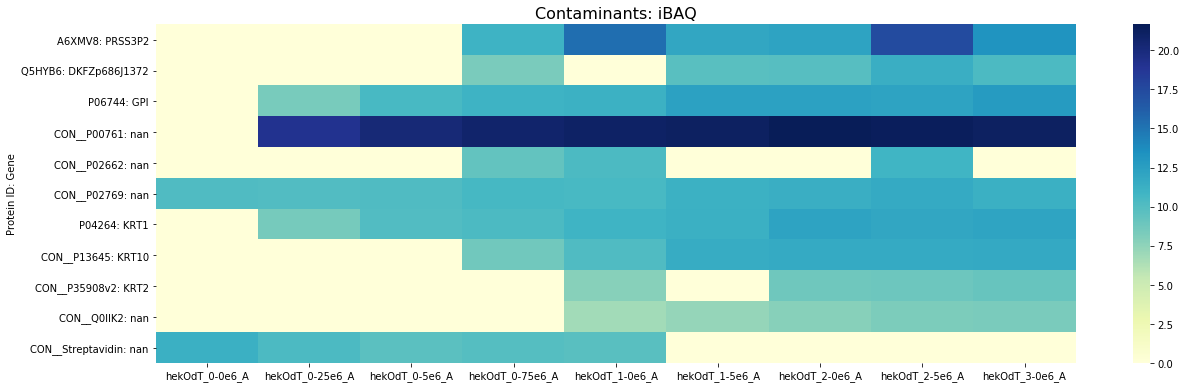

In [24]:
#### Visaully inspect contaminants  
jvis.MQ_getContaminants_sbplot(contaminants, metadata, width = 5, length = 2, layout = 'single')

### Results: GOOD  
All contaminants increase in intensity as the input increases- this is to be expected.  
An exception to this is stretavidin which reduces in concentration as the inputs increase. Perhaps this is due to the the streptavidin signal being outcompeted (thus an illustration of dynamic range).  

## 5. Assess Digestion Efficiency  
__Functions__  
jinspect.MQ_getMissedCleavages( )  
jvis.LinePlotByGroup_sbplot( )  
  
Assessing missed cleavages is an essential metric for understanding the quality of the tryptic digestion. This data is recorded in the evidence file.  
___jinspect.MQ_getMissedCleavages( )___ will return a long form data table that can easily be used for plotting.  
We'll plot the missed cleavages with the generic function __jvis.LinePlotByGroup_sbplot( )__  

In [25]:
#### Extract the missed cleavage data into a long form table for plotting
MissedCleavages = jinspect.MQ_getMissedCleavages(evidence, metadata, drop_contaminants = True)
MissedCleavages.sort_values(by=['sample'], inplace = True)
MissedCleavages

,sample,% Missed Cleavages,group,expt
3,hekOdT_0-0e6_A,0,hekOdT_0-0e6,hekOdT
0,hekOdT_0-25e6_A,24,hekOdT_0-25e6,hekOdT
8,hekOdT_0-5e6_A,27,hekOdT_0-5e6,hekOdT
4,hekOdT_0-75e6_A,28,hekOdT_0-75e6,hekOdT
7,hekOdT_1-0e6_A,28,hekOdT_1-0e6,hekOdT
5,hekOdT_1-5e6_A,29,hekOdT_1-5e6,hekOdT
2,hekOdT_2-0e6_A,29,hekOdT_2-0e6,hekOdT
1,hekOdT_2-5e6_A,30,hekOdT_2-5e6,hekOdT
6,hekOdT_3-0e6_A,30,hekOdT_3-0e6,hekOdT


<Figure size 432x288 with 0 Axes>

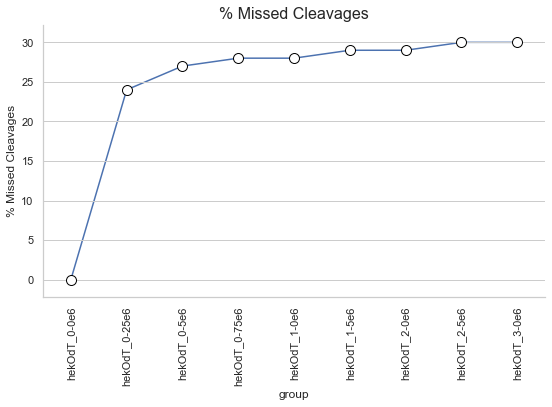

In [80]:
#### Plot the grouped data points  
sns.set_style('whitegrid')
jvis.LinePlotByGroup_sbplot(MissedCleavages, x_col = 'group', y_col = '% Missed Cleavages', title = '% Missed Cleavages')

### Results: AVERAGE-POOR 
This is an ISD-ST preparation but the missed cleavage rate comparable to SP3/USP3.  
I used very little trypsin in this experiment.  See missed cleavage results for Expt.311 and adjust accordingly for future experiments. 

## 6. Remove Contaminants  
__Functions__  
jwrangle.MQ_getThreePassFilter( )   
SeqIO.parse( )

After QC we no longer want the contaminants in our data.  __jwrangle.MQ_getThreePassFilter( )__ will remove reverse peptides, contaminants, and only identified by site from MQ tables.  
The filter will also accept customised exclusion lists in case users have added odd protein species to the search FASTA tables. In this particular experiment we added to the human FASTA, RNAse proteins and the large T antigen. The former as 1) a check that dynamic range is not being overwhelmed and 2) as an quantitative spike-in control to compare tryptic efficiency and the sample recovery across samples following C18 cleanup.

In [30]:
#### Map the location of the custom FASTA elements
os.listdir(base_path / 'my_resources' / 'FASTA')  

#### Create a list of the non-human proteins that were added to the custom FASTA genome search. 
new_cont = []
with open(base_path / 'my_resources' / 'FASTA' / "custom_proteome_elements.fasta", "r") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        new_cont.append(record.id.split('|')[1])

#### Remove all unwanted contaminants and IDs from the proteinGroups table      
pGroup_clean = jwrangle.MQ_getThreePassFilter(pGroups_map, custom_exclusion = new_cont)

#### Inspect the cleaned dataframe
pGroup_clean[['ENTREZGENE_gPro primary'] + [i for i in pGroup_clean.columns if 'iBAQ' in i]].head(2)

,ENTREZGENE_gPro primary,iBAQ,iBAQ hekOdT_0-0e6_A,iBAQ hekOdT_0-25e6_A,iBAQ hekOdT_0-5e6_A,iBAQ hekOdT_0-75e6_A,iBAQ hekOdT_1-0e6_A,iBAQ hekOdT_1-5e6_A,iBAQ hekOdT_2-0e6_A,iBAQ hekOdT_2-5e6_A,iBAQ hekOdT_3-0e6_A
0,NSRP1,48533.0,0.0,0.0,0.0,1231.30,2291.00,6799.2,13144.0,5478.9,19588.0
1,CDK1,8977.7,0.0,0.0,0.0,701.64,687.44,1381.6,1739.8,1953.7,2513.6


## 7. Drop Gene Duplicates and Filter Intensities by LFQ  
__Functions__  
jinspect.MQ_dropDuplicateIDs( )    
  
The next step focuses on improving confidence in the quality of our data. This is done by applying __jinspect.MQ_dropDuplicateIDs( )__ which has the below effects:   
  
* Because one gene can have many proteins, sometimes Maxquant will create multiple proteinGroups for a single gene. As most of our analysis focuses on genes we'll trim the lowest quality proteinGroups duplicates from the table.  
* Standard LFQ defaults require a minimum of 2 peptide species, at least one of which must be unique, for quantitation to be applied. Intensity and iBAQ values, however, do not have such a minimum limit. I consider a 2 peptide minimum to be a wise filter but still have use for the Intensity and iBAQ values. Thus where the LFQ filter is applied all measurements that do not meet the minimum limit will be discarded. In short, if there isn't a companion LFQ value, there won't be an Intensity or iBAQ value either after filtering.  
* It has been documented that Match Between Runs suffers a high frequency of false peptide transfers (Lim, Paulo, Gygi 2019; doi: 10.1021/acs.jproteome.9b00492). At the protein level, however, this false transfer rate is greatly mitigated by the minimum peptide rule applied by the LFQ algorithm. This is another good reason for our filtering step.    

In [31]:
#### Drop duplicates and apply LFQ filter
filter_dict = jinspect.MQ_dropDuplicateIDs(pGroup_clean, metadata, prefix = 'Peptides', ID = 'ENTREZGENE_gPro primary', pool = 'measure', drop_ID = 'None', 
                                            keep_PoolCalcs = False, applyLFQ_filter = ['Intensity', 'iBAQ'])
#### Inspect filter dictionary
filter_dict.keys()

dict_keys(['df_keep', 'df_droprows'])

In [32]:
#### The df_keep value contains our targets, df_droprows conatins the discarded duplicates. Assign the df_keep value to a new variable and inspect.
pGroup_filtered = filter_dict['df_keep']
pGroup_filtered.head(2)

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Protein names,Gene names,Fasta headers,Number of proteins,Peptides,...,Intensity hekOdT_3-0e6_A,iBAQ hekOdT_0-0e6_A,iBAQ hekOdT_0-25e6_A,iBAQ hekOdT_0-5e6_A,iBAQ hekOdT_0-75e6_A,iBAQ hekOdT_1-0e6_A,iBAQ hekOdT_1-5e6_A,iBAQ hekOdT_2-0e6_A,iBAQ hekOdT_2-5e6_A,iBAQ hekOdT_3-0e6_A
0,K7ERM9;A0A024QZ33;Q9H0G5;K7EK40;K7EMD8,K7ERM9;A0A024QZ33;Q9H0G5;K7EK40;K7EMD8,2;2;2;1;1,2;2;2;1;1,2;2;2;1;1,Nuclear speckle splicing regulatory protein 1,NSRP1;CCDC55,;;;;,5,2,...,117530.0,0.0,0.0,0.0,0.0,0.0,6799.2,13144.0,0.0,19588.0
1,E5RIU6;A0A087WZZ9;A0A024QZP7;P06493;P06493-2,E5RIU6;A0A087WZZ9;A0A024QZP7;P06493;P06493-2,2;2;2;2;1,1;1;1;1;1,1;1;1;1;1,Cyclin-dependent kinase 1,CDK1;CDC2,;;;;,5,2,...,32677.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2513.6


## 8. Review Sample Clustering by Group  
__Functions__  
jtest.getDistanceMatrix( )  
jvis.MQ_showDendrogramQC_mplplot( )  
  
A distance matrix function __jtest.getDistanceMatrix( )__ is provided for users who wish to apply different algorithms or create different visualisations.  
I like the 'ward' method for distance calculations and using a dengrogram to confirm that clustering matches expectations and so use a prerolled function __jvis.MQ_showDendrogramQC_mplplot( )__  

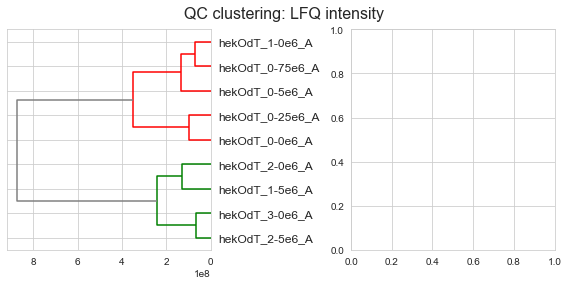

In [35]:
#### Confirm that clustering matches expectations
jvis.MQ_showDendrogramQC_mplplot(pGroup_filtered, 'LFQ intensity', metadata, 'QC clustering: ', grid = 'YES', fsize = (8, 4))

### Result: GOOD  
A dendrogram is not ideal here but it will do. The two major clusters are 50/50 bewteen the lowest and highest inputs. This is to be expected.  

## 9. Compare Intensity Distribution and Sequence Coverage   
__Functions__  
jwrangle.MQ_poolDataByCondition( )  
jvis.BoxPlotByColumn_sbplot( )  
jvis.CommonPalettesAsHex  
  
Next we will compare intensity and sequence coverage between groups. Log2 transformation has already been performed so we need only use __jwrangle.MQ_poolDataByCondition( )__ to create the appropriate long form dataset for plotting with __jvis.BoxPlotByColumn_sbplot( )__.  The dictionary __jvis.CommonPalettesAsHex__ contains a number of palettes that are common to both matplotlib and ggplot (from R). These are provided to ensure consistency is easy to achieve across both languages.  


In [39]:
#### Log2 transform available intensity values.
pGroup_log2 = jwrangle.Log2_ByPrefix(pGroup_filtered, 'LFQ intensity')
pGroup_log2 = jwrangle.Log2_ByPrefix(pGroup_log2, 'iBAQ')
pGroup_log2 = jwrangle.Log2_ByPrefix(pGroup_log2, 'Intensity')
pGroup_log2.replace(0,np.nan, inplace=True)

In [43]:
#### Pool data into a single long form dataset
pooled_dfDropGroupOne = jwrangle.MQ_poolDataByCondition(pGroup_log2, metadata, prefix_list = ['Intensity', 'Sequence coverage'])

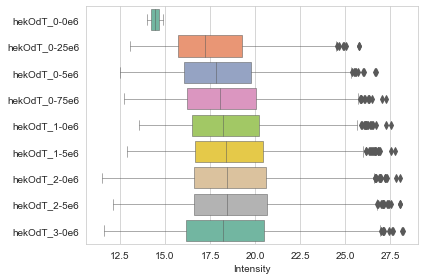

In [44]:
### Select a colour palette  
cpal = jvis.CommonPalettesAsHex

set2_paired = []
for i in cpal['Set2_qual']:
    set2_paired.append(i)
    set2_paired.append(i)

#### Compare Intensity distribution using a box and whisker plot
sns.set_style('whitegrid')
jvis.BoxPlotByColumn_sbplot(pooled_dfDropGroupOne, 'Intensity: ', 'Intensity')

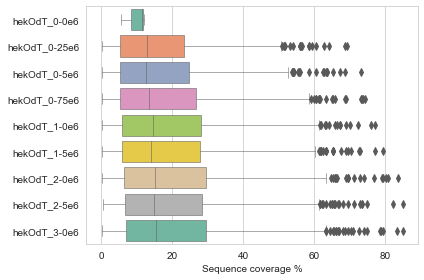

In [45]:
#### Compare Sequence coverage using a box and whisker plot
sns.set_style('whitegrid')
jvis.BoxPlotByColumn_sbplot(pooled_dfDropGroupOne, 'Sequence coverage: ', 'Sequence coverage %')

### Result: GOOD  
These results are consistent with expectations.   

## 10. Compare Sum Peptide Counts  
__Functions__  
jinspect.MQ_getSumBySample( )  
jvis.LinePlotByGroup_sbplot( )  
  
To sum the total peptides observed across all proteins use ___jinspect.MQ_getSumBySample( )___. These sums will be returned as a modified metadata table.  
Plotting these by group is easily done with __jvis.LinePlotByGroup_sbplot( )__. The plotting order is determined by the metadata ordering.  
In this case we are inspecting the number of peptides detected after having removed contaminants- thus if some spike-in proteins were removed, i.e. in this case RNAse treatments, they will not contribute to the peptide count. To look at the replicability of these spike-ins, we would reach back to the 'df_droprows' table generated by __jinspect.MQ_dropDuplicateIDs( )__ in section 7.

In [46]:
#### Extract the total peptides observed per sample
metaStats = jinspect.MQ_getSumBySample(pGroup_log2, metadata, freqList = ['Peptides'], measure = False)
metaStats

,experiment,condition,replicate,sample,measure,MQgroups,Peptides
0,0_hekOdT_blank_Slot1-3_1_4175,hekOdT_0-0e6,A,hekOdT_0-0e6_A,Intensity,hekOdT,5.0
1,1_hekOdT_0-25e6_Slot1-4_1_4176,hekOdT_0-25e6,A,hekOdT_0-25e6_A,Intensity,hekOdT,6656.0
2,2_hekOdT_0-5e6_Slot1-5_1_4177,hekOdT_0-5e6,A,hekOdT_0-5e6_A,Intensity,hekOdT,9398.0
3,3_hekOdT_0-75e6_Slot1-6_1_4178,hekOdT_0-75e6,A,hekOdT_0-75e6_A,Intensity,hekOdT,11099.0
4,4_hekOdT_1-0e6_Slot1-7_1_4179,hekOdT_1-0e6,A,hekOdT_1-0e6_A,Intensity,hekOdT,12398.0
5,5_hekOdT_1-5e6_Slot1-8_1_4180,hekOdT_1-5e6,A,hekOdT_1-5e6_A,Intensity,hekOdT,13465.0
6,6_hekOdT_2-0e6_Slot1-9_1_4181,hekOdT_2-0e6,A,hekOdT_2-0e6_A,Intensity,hekOdT,15113.0
7,7_hekOdT_2-5e6_Slot1-10_1_4182,hekOdT_2-5e6,A,hekOdT_2-5e6_A,Intensity,hekOdT,15321.0
8,8_hekOdT_3-0e6_Slot1-11_1_4183,hekOdT_3-0e6,A,hekOdT_3-0e6_A,Intensity,hekOdT,15879.0


<Figure size 432x288 with 0 Axes>

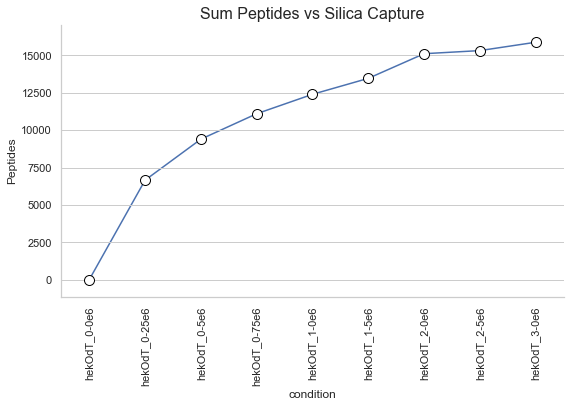

In [74]:
#### Plot the sum peptides
sns.set_style('whitegrid')
jvis.LinePlotByGroup_sbplot(metaStats, x_col = 'condition', y_col = 'Peptides', title = 'Sum Peptides vs Silica Capture', errorbars = 'SEM')

### Results: GOOD    
Nice curve!  

## 11. Compare Unique Gene Counts  
__Functions__  
jinspect.MQ_getFrequencyBySample( )  
  
One gene can encode for many proteins that often share regions of similarity. As for illumina-based RNA-Seq, however, shotgun proteomics can rarely assign a peptide species to a singular protein. In MaxQuant these are called proteinGroups. Because we have do not require protein-specific results, and gene identity is more stable, our gene count describes the groups to which our detected proteins have been be assigned. Thus gene here is being detected by protein product, just as it would be detected by RNA product in RNA Seq; none of these 3 are synonymous. To be clear, this is a count and not a measure.

Gene frequency is defined by the summed observations per protein regardless of intensity value and this data is extracted to our modified metadata with __jinspect.MQ_getFrequencyBySample( )__ .   
A typical MQ search will yield identical protein counts (though different values) for Intensity and iBAQ*.  LFQ frequencies will vary depending on the search settings:  
* In this case the MQ search has set LFQ values to be calculated on a min 2 peptide ratio (this is the default)** 

_Notes_  
\* Why protein counts should be identical I don't know. The original iBAQ paper stipulates rules for the inclusion of a protein in the iBAQ calculation but MaxQuant doesn't seem to apply them.  
\** Previously I tested LFQ min ratio at 1 peptide. At 1 minimum peptide there was unexpected QC clustering. Possible explanations for this are explained in section 7 and are cleaned up by __jinspect.MQ_dropDuplicateIDs( )__ function. We can expect this function to greatly reduce qualifying IDs (~20% fewer), especially in the QE samples, but I think the trade-off is worth it because we gain 1) a more robust ID check and 2) the same search can be used for LFQ based checks of dynamic changes, i.e. comparing more than one group of cCL captures for biological changes.  

In [75]:
#### Count the number of unique 
metaStats = jinspect.MQ_getFrequencyBySample(pGroup_log2, metaStats, freqList = ['Intensity', 'iBAQ', 'LFQ intensity'], measure = False)
metaStats

,experiment,condition,replicate,sample,measure,MQgroups,Peptides,Intensity,iBAQ,LFQ intensity
0,0_hekOdT_blank_Slot1-3_1_4175,hekOdT_0-0e6,A,hekOdT_0-0e6_A,Intensity,hekOdT,5.0,2,2,2
1,1_hekOdT_0-25e6_Slot1-4_1_4176,hekOdT_0-25e6,A,hekOdT_0-25e6_A,Intensity,hekOdT,6656.0,772,772,772
2,2_hekOdT_0-5e6_Slot1-5_1_4177,hekOdT_0-5e6,A,hekOdT_0-5e6_A,Intensity,hekOdT,9398.0,1022,1022,1022
3,3_hekOdT_0-75e6_Slot1-6_1_4178,hekOdT_0-75e6,A,hekOdT_0-75e6_A,Intensity,hekOdT,11099.0,1157,1157,1157
4,4_hekOdT_1-0e6_Slot1-7_1_4179,hekOdT_1-0e6,A,hekOdT_1-0e6_A,Intensity,hekOdT,12398.0,1261,1261,1261
5,5_hekOdT_1-5e6_Slot1-8_1_4180,hekOdT_1-5e6,A,hekOdT_1-5e6_A,Intensity,hekOdT,13465.0,1378,1378,1378
6,6_hekOdT_2-0e6_Slot1-9_1_4181,hekOdT_2-0e6,A,hekOdT_2-0e6_A,Intensity,hekOdT,15113.0,1578,1578,1578
7,7_hekOdT_2-5e6_Slot1-10_1_4182,hekOdT_2-5e6,A,hekOdT_2-5e6_A,Intensity,hekOdT,15321.0,1659,1659,1659
8,8_hekOdT_3-0e6_Slot1-11_1_4183,hekOdT_3-0e6,A,hekOdT_3-0e6_A,Intensity,hekOdT,15879.0,1901,1901,1901


<Figure size 432x288 with 0 Axes>

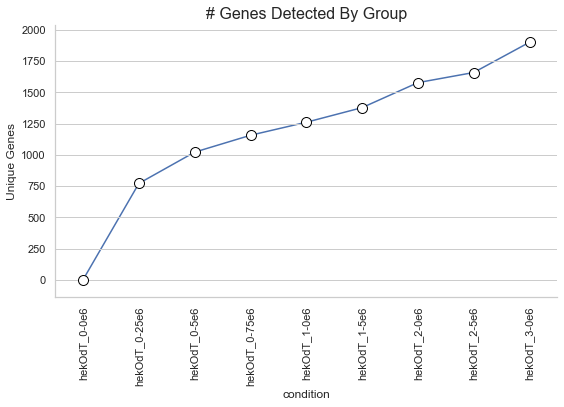

In [77]:
#### Plot the counts
sns.set_style('whitegrid')
jvis.LinePlotByGroup_sbplot(metaStats, x_col = 'condition', y_col = 'Intensity', title = '# Genes Detected By Group', 
                           pal = set2_paired, ylabel = 'Unique Genes', errorbars = 'SEM')

### Results: AVERAGE  
We are not getting a taper. Interesting that the peptide count would taper but the protein count doesn't. It's worth repeating this experiment with high cell numbers.

## 12. Investigate Predicted RBP % by Input  
__Functions__  
jwrangle.importMixedFiles( )  
jweb.fetchQuickGO( )  
jweb.mapAnyID( )
jwrangle.concatGO_DataFrameDict( )
  
It will be interesting to investigate whether the % of known or predicted RBPs is stable across all input amounts. The assignment of RBP identification, however, is still a subject of debate. I keep a resources folder that includes RBP identifications made by various studies, and also a metadata table of Gene Ontology (GO) categories of interest. Here, we'll fetch the custom GO metadata using  __jwrangle.importMixedFiles( )__, select the categories of interest and then fetch the relevant gene names from the GO database. The function __jweb.fetchQuickGO( )__ has many customisable features, see help() for details, but the ones we use here shall:  
  
a) Extract a customised dataset for all _proteins_ in the QuickGO which belong to the category that we query.  
b) Uses a consistent mapping algorithm based on __jweb.mapAnyID( )__ to derive a gene symbol and name.  
c) Annotates each query protein according to its SwissProt of TrEMBL status.  
    
With the QuickGo data in hand we'll do a quick survey of the % known RBP in each input.

In [82]:
#### Import all files in my resources folder and inspect the available files
MyResources = jwrangle.importMixedFiles(base_path / 'my_resources')
MyResources.keys()

dict_keys(['.ipynb_checkpoints', 'control_elements', 'control_proteins', 'custom_dfs', 'FASTA', 'GOexplore.ipynb', 'GO_TermsOfInterest.csv', 'GO_TermsOfInterest_stats.csv', 'instrumentQC', 'New folder', 'testing.py'])

In [96]:
#### Inspect the custom file we are interested in
MyResources['GO_TermsOfInterest.csv'].head(18)

,GO Term,relationship,depth,go ID,Description,ctrl list type,parent(s)
0,binding,Molecular Function,1,GO:0005488,NaN,NaN,GO:0003674
1,protein binding,Molecular Function,2,GO:0005515,NaN,NaN,GO:0005488
2,chromatin binding,Molecular Function,2,GO:0003682,NaN,NaN,GO:0005488
3,nucleic acid binding,Molecular Function,3,GO:0003676,NaN,NaN,GO:0003676
4,DNA binding,Molecular Function,4,GO:0003677,NaN,general,GO:0003676
5,RNA binding,Molecular Function,4,GO:0003723,NaN,general,GO:0003676
6,DNA/RNA hybrid binding,Molecular Function,4,GO:0071667,NaN,general,GO:0003676
7,translation regulator activity,Molecular Function,4,GO:0090079,NaN,NaN,GO:0003676
8,regulatory region nucleic acid binding,Molecular Function,4,GO:0001067,NaN,NaN,GO:0003676
9,annealing activity,Molecular Function,4,GO:0097617,NaN,NaN,GO:0003676


In [87]:
#### As a list, pick out the codes we are interested in, in this case RNA-binding (depth 4) and two child tags mRNA binding (depth 5), and rRNA binding (depth 5).
go_list = ['GO:0003723', 'GO:0003729', 'GO:0019843']

#### Fetch the QuickGo data on each category and save the file locally. The number of records and a URL (for manual searching) will be printed to console.
#### If data is saved code only need to be run once, hence it is hashed.
# GO_dict = jweb.fetchQuickGO(go_list, QG_geneProductType = 'protein', QG_taxonId = '9606', QG_geneProductSubset = ['Swiss-Prot', 'TrEMBL'], 
#                             gConvertTarget='ENTREZGENE', gConvertOrganism = 'hsapiens', writetopath = 'YES')

#### Import the local QuickGO Data and inspect the files
GO_dict = jwrangle.importMixedFiles(cwd / 'downloads' / 'QuickGo')
GO_dict.keys()

GO0003723_Swiss-Prot has 5245 records: 
https://www.ebi.ac.uk/QuickGO/annotations?goId=GO:0003723&taxonId=9606&taxonUsage=exact&goUsage=descendants&geneProductType=protein&geneProductSubset=Swiss-Prot

GO0003723_TrEMBL has 4976 records: 
https://www.ebi.ac.uk/QuickGO/annotations?goId=GO:0003723&taxonId=9606&taxonUsage=exact&goUsage=descendants&geneProductType=protein&geneProductSubset=TrEMBL

GO0003729_Swiss-Prot has 573 records: 
https://www.ebi.ac.uk/QuickGO/annotations?goId=GO:0003729&taxonId=9606&taxonUsage=exact&goUsage=descendants&geneProductType=protein&geneProductSubset=Swiss-Prot

GO0003729_TrEMBL has 277 records: 
https://www.ebi.ac.uk/QuickGO/annotations?goId=GO:0003729&taxonId=9606&taxonUsage=exact&goUsage=descendants&geneProductType=protein&geneProductSubset=TrEMBL

GO0019843_Swiss-Prot has 95 records: 
https://www.ebi.ac.uk/QuickGO/annotations?goId=GO:0019843&taxonId=9606&taxonUsage=exact&goUsage=descendants&geneProductType=protein&geneProductSubset=Swiss-Prot

GO0019843_

dict_keys(['GO0003723_Swiss-Prot_hsapiens_protein-ENTREZGENE.csv', 'GO0003723_TrEMBL_hsapiens_protein-ENTREZGENE.csv', 'GO0003729_Swiss-Prot_hsapiens_protein-ENTREZGENE.csv', 'GO0003729_TrEMBL_hsapiens_protein-ENTREZGENE.csv', 'GO0019843_Swiss-Prot_hsapiens_protein-ENTREZGENE.csv', 'GO0019843_TrEMBL_hsapiens_protein-ENTREZGENE.csv'])

In [100]:
#### Inspect one of the datasets  
GO_dict['GO0019843_TrEMBL_hsapiens_protein-ENTREZGENE.csv'].head(2)

,GENE_PRODUCT_DB,GENE_PRODUCT_ID,QUALIFIER_QGO,GO_TERM,REFERENCE,ECO_ID,WITH/FROM,ASSIGNED_BY,ANNOTATION_EXTENSION_QGO,GO_EVIDENCE_CODE,ENTREZGENE_gPro all,ENTREZGENE_gPro primary,ENTREZGENE_gPro name,UNIPROT_gPro status
0,UniProtKB,A0A024R0A2,enables,GO:0019843,GO_REF:0000043,ECO:0000323,UniProtKB-KW:KW-0699,UniProt,NaN,IEA,None,None,None,None
1,UniProtKB,A0A024R4M0,enables,GO:0019843,GO_REF:0000002,ECO:0000256,InterPro:IPR001912|InterPro:IPR018079,InterPro,NaN,IEA,RPS9,RPS9,ribosomal protein S9 [Source:HGNC Symbol;Acc:H...,TREMBL


In [109]:
#### Extract the list of stably mapped genes for positive IDs in each sample
GeneListBySample = {}
for k in [i for i in pGroup_log2 if 'Intensity ' in i]:
    hitlist = pGroup_log2[pGroup_log2[k]>0]['ENTREZGENE_gPro primary']
    GeneListBySample[k.replace('Intensity ', '')] = hitlist

#### Calculate the Gene Count, known RBP count, and %RBP for each sample   
RBPcountBySample = []
for key, val in GeneListBySample.items():
    sub=[]
    sub.append(key)
    sub.append(len(val))
    RBP_count = len(set(val).intersection(GO_dict['GO0003723_Swiss-Prot_hsapiens_protein-ENTREZGENE.csv']['ENTREZGENE_gPro primary'].tolist()))
    sub.append(RBP_count)
    sub.append(int((RBP_count / len(val)) * 100))
    RBPcountBySample.append(sub)
    
#### Build Dataframe
RBP_GO0003723_SwissProt = pd.DataFrame(RBPcountBySample)
RBP_GO0003723_SwissProt.columns = ['Sample', 'Genes', 'Known RBPs', '% RBP']
RBP_GO0003723_SwissProt

,Sample,Genes,Known RBPs,% RBP
0,hekOdT_0-0e6_A,2,0,0
1,hekOdT_0-25e6_A,772,664,86
2,hekOdT_0-5e6_A,1022,798,78
3,hekOdT_0-75e6_A,1157,854,73
4,hekOdT_1-0e6_A,1261,888,70
5,hekOdT_1-5e6_A,1378,920,66
6,hekOdT_2-0e6_A,1578,974,61
7,hekOdT_2-5e6_A,1659,983,59
8,hekOdT_3-0e6_A,1901,1036,54


<Figure size 432x288 with 0 Axes>

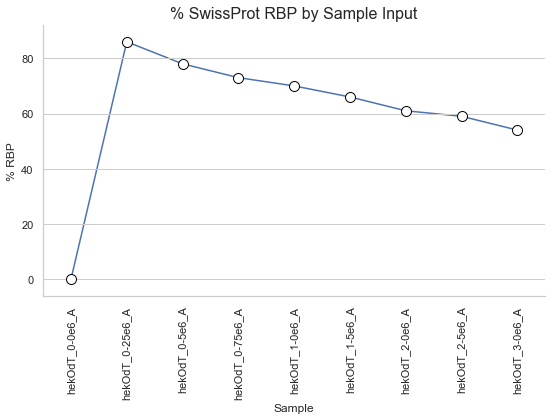

In [115]:
# import seaborn as sns; sns.set()
# import matplotlib.pyplot as plt
ax = jvis.LinePlotByGroup_sbplot(RBP_GO0003723_SwissProt, x_col="Sample", y_col="% RBP", title = '% SwissProt RBP by Sample Input')

### Results: INTERESTING  
The known RBP % falls linearly from its peak at the lowest cellular input of 250e6 RBP extraction.  
This could imply that  
1. the extraction protocol loses specificity with more material. _Not possible here:_ These samples come from the same extraction, they just use different relative loading amounts.
2. more background crosses into the limit of detection as more material is used (likely)  
3. more RBPs are crossing into the limit of detection: discovery depth is improving as due to increased sensitivity (hopeful, though also likely)  
We cannot assume a captured protein is an RBP, a classification scheme is required to measure confidence in identification.  

__Expanding beyond SwissProt__  
SwissProt entries are reviewed, though we might wish to include unreviewed TrEMBL proteins in our GO checks. We can use __jwrangle.concatGO_DataFrameDict( )__ pool the SwissProt and TrEMBL dictionaries fetched by __jweb.fetchQuickGO( )__. The concatenation function will work on dictionaries of dataframes, so there is no need to concatenate and clean every pair individually.

In [116]:
#### Pool SwissProt and TrEMBL entries together on the basis of GO ID
GO_dict_concat = jwrangle.concatGO_DataFrameDict(GO_dict)
GO_dict_concat.keys()

dict_keys(['GO0003723', 'GO0003729', 'GO0019843'])

In [117]:
#### Recalculate the Gene Count, known RBP count, and %RBP for each sample   
RBPcountBySample = []
for key, val in GeneListBySample.items():
    sub=[]
    sub.append(key)
    sub.append(len(val))
    RBP_count = len(set(val).intersection(GO_dict_concat['GO0003723']['ENTREZGENE_gPro primary'].tolist()))
    sub.append(RBP_count)
    sub.append(int((RBP_count / len(val)) * 100))
    RBPcountBySample.append(sub)

#### Build Dataframe
RBP_GO0003723_All = pd.DataFrame(RBPcountBySample)
RBP_GO0003723_All.columns = ['Sample', 'Genes', 'Known RBPs', '% RBP']
RBP_GO0003723_All

,Sample,Genes,Known RBPs,% RBP
0,hekOdT_0-0e6_A,2,0,0
1,hekOdT_0-25e6_A,772,666,86
2,hekOdT_0-5e6_A,1022,801,78
3,hekOdT_0-75e6_A,1157,858,74
4,hekOdT_1-0e6_A,1261,891,70
5,hekOdT_1-5e6_A,1378,924,67
6,hekOdT_2-0e6_A,1578,980,62
7,hekOdT_2-5e6_A,1659,989,59
8,hekOdT_3-0e6_A,1901,1042,54


### Results: NO DIFFERENCE  
Well that was anticlimactic, though worthwhile nonethless.  

__Average Intensity Among Input Sets__  
For the proteins uniquely detected among the higher input sets- does intensity fall when approaching 0 input? Such a trend would be expected high protein IDs were related to crossing a threshold of sensitivity.  
Making such a plot is going to be a bit of a chore (with a fairly obvious result) so let's leave this for a rainy day.  

## Conclusions  
Peak peptides detection is reached at 2e6 HEK293T RBP extracted cellular input.  
Protein/Gene IDs, however, continue to scale up linearly.  
The peptide data is telling us that at 2e6 we are reaching the loading limit for our HPLC setup. Thus, even if we wanted to explore where protein ID rate levels off, it would involve overloading the columns; not ideal from a technical standpoint.  
The decline in % RBP with increasing genes found is either a function of elevated backgrounds or improved discovery. To determine which, a comparative analysis of nCL and cCL samples must be performed.